# Data Loading/Prep

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import *
import string
from tqdm.notebook import tqdm
# stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/danielvangelder/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
TEST_BODIES_PATH = "data/fnc-1/competition_test_bodies.csv"
TEST_STANCES_PATH = "data/fnc-1/competition_test_stances.csv"
TRAIN_BODIES_PATH = "data/fnc-1/train_bodies.csv"
TRAIN_STANCES_PATH = "data/fnc-1/train_stances.csv"
ALBERT_PREDICTIONS = "data/fnc-1/golden_labels_2.csv"
BASELINE_PREDICTIONS = "data/fnc-1/baseline_output.csv"


## Loading Bodies and Stances for both models

In [3]:
def create_merged_df(bodies_path, stances_path):
    bodies = pd.read_csv(bodies_path, names=['Body ID', 'articleBody'], header=0)
    stances = pd.read_csv(stances_path, names=['Headline', 'Body ID', 'Stance'], header=0)
    df = pd.merge(bodies, stances, on='Body ID')
    return df


albert = pd.read_csv(ALBERT_PREDICTIONS, names=['Headline', 'Body ID', 'Stance'], header=0)
baseline = pd.read_csv(BASELINE_PREDICTIONS, names=['Headline', 'Body ID', 'Stance'], header=0)
baseline.columns = ['Headline', 'Body ID', 'Stance_baseline']
test_res = create_merged_df(TEST_BODIES_PATH, TEST_STANCES_PATH)
# test_res['albert'] = pd.malbert[['Headline', 'Stance']]
test_res = pd.merge(test_res,albert, on=['Headline', 'Body ID'], suffixes=['_true', '_albert'])
test_res = pd.merge(test_res,baseline, on=['Headline', 'Body ID'])
train = create_merged_df(TRAIN_BODIES_PATH, TRAIN_STANCES_PATH)
# display(test_res)
# display(train)

In [4]:
print("A few sanity checks:")
correct_agree_albert = test_res.loc[(test_res['Stance_true'] == 'agree') & (test_res['Stance_albert'] == 'agree')].shape[0]
correct_agree_base = test_res.loc[(test_res['Stance_true'] == 'agree') & (test_res['Stance_baseline'] == 'agree')].shape[0]
print(f"Amount of agrees, predicted by ALBERT as agree: {correct_agree_albert}")
print(f"Amount of agrees, predicted by baseline as agree: {correct_agree_base}")


agree_disagree_albert = test_res.loc[(test_res['Stance_true'] == 'agree') & (test_res['Stance_albert'] == 'disagree')].shape[0]
print(f"Amount of agrees, predicted by ALBERT as disagree: {agree_disagree_albert}")
correct_unrelated = test_res.loc[(test_res['Stance_true'] == 'unrelated') & (test_res['Stance_baseline'] == 'unrelated')].shape[0]
print(f"Amount of unrelated pairs, correctly predicted by baseline as unrelated: {correct_unrelated}")


def get_confusion_value(true_label, predicted_label):
    return test_res.loc[(test_res['Stance_true'] == true_label) & (test_res['Stance_albert'] == predicted_label)].shape[0]
confusion_matrix_albert = [[get_confusion_value('agree', 'agree'),get_confusion_value('agree', 'disagree'),get_confusion_value('agree', 'discuss'),get_confusion_value('agree', 'unrelated')],
             [test_res.loc[(test_res['Stance_true'] == 'disagree') & (test_res['Stance_albert'] == 'agree')].shape[0],
            test_res.loc[(test_res['Stance_true'] == 'disagree') & (test_res['Stance_albert'] == 'disagree')].shape[0],
            test_res.loc[(test_res['Stance_true'] == 'disagree') & (test_res['Stance_albert'] == 'discuss')].shape[0],
            test_res.loc[(test_res['Stance_true'] == 'disagree') & (test_res['Stance_albert'] == 'unrelated')].shape[0]],
             [test_res.loc[(test_res['Stance_true'] == 'discuss') & (test_res['Stance_albert'] == 'agree')].shape[0],
            test_res.loc[(test_res['Stance_true'] == 'discuss') & (test_res['Stance_albert'] == 'disagree')].shape[0],
            test_res.loc[(test_res['Stance_true'] == 'discuss') & (test_res['Stance_albert'] == 'discuss')].shape[0],
            test_res.loc[(test_res['Stance_true'] == 'discuss') & (test_res['Stance_albert'] == 'unrelated')].shape[0]],
             [test_res.loc[(test_res['Stance_true'] == 'unrelated') & (test_res['Stance_albert'] == 'agree')].shape[0],
            test_res.loc[(test_res['Stance_true'] == 'unrelated') & (test_res['Stance_albert'] == 'disagree')].shape[0],
            test_res.loc[(test_res['Stance_true'] == 'unrelated') & (test_res['Stance_albert'] == 'discuss')].shape[0],
            test_res.loc[(test_res['Stance_true'] == 'unrelated') & (test_res['Stance_albert'] == 'unrelated')].shape[0]]]
print(f"confusion matrix for ALBERT: {confusion_matrix_albert}")

A few sanity checks:
Amount of agrees, predicted by ALBERT as agree: 1120
Amount of agrees, predicted by baseline as agree: 191
Amount of agrees, predicted by ALBERT as disagree: 84
Amount of unrelated pairs, correctly predicted by baseline as unrelated: 18967
confusion matrix for ALBERT: [[1120, 84, 495, 303], [224, 177, 118, 176], [739, 153, 3338, 582], [85, 34, 218, 19014]]


In [5]:
test_headlines = set(test_res['Headline'].values)
train_count = 0
for headline in train['Headline'].values:
    if headline in test_headlines:
        train_count += 1

train_length = len(train['Headline'].values)
print(f"There are {train_count} train headlines that occur in the test set out of {train_length}")


train_headlines = set(train['Headline'].values)
test_count = 0
for headline in test_res['Headline'].values:
    if headline in train_headlines:
        test_count += 1
test_length = len(test_res['Headline'].values)
print(f'There are {test_count} test headlines that occur in the train set out of {test_length}')

print(f'We have {len(train_headlines)} unique train headlines and {len(test_headlines)}, the intersection has size {len(train_headlines.intersection(test_headlines))}')

There are 156 train headlines that occur in the test set out of 49972
There are 155 test headlines that occur in the train set out of 26860
We have 1648 unique train headlines and 893, the intersection has size 10


## Discard Unrelated Instances and Map Model Stances to Correctness

In [6]:
test_res_rel = test_res.loc[test_res['Stance_true'] != 'unrelated']
correct = test_res_rel.copy()
correct['correct_albert'] = test_res_rel['Stance_true'] == test_res_rel['Stance_albert']
correct['correct_base'] = test_res_rel['Stance_true'] == test_res_rel['Stance_baseline']
correct = correct[['articleBody', 'Headline', 'Stance_true', 'correct_albert', 'correct_base']]
display(correct)

,articleBody,Headline,Stance_true,correct_albert,correct_base
1,Al-Sisi has denied Israeli reports stating tha...,El-Sisi denies claims he'll give Sinai land to...,agree,True,False
34,A bereaved Afghan mother took revenge on the T...,Afghan Mother Kills 25 Taliban Fighters In Sev...,agree,True,False
107,CNBC is reporting Tesla has chosen Nevada as t...,REPORT: Tesla Chooses Nevada For Site Of Its M...,discuss,True,True
201,A 4-inch version of the iPhone 6 is said to be...,4-inch iPhone 6 reported to be in development,discuss,True,True
208,GR editor’s Note\n\nThere are no reports in th...,Iraqi Army Downs Two British Planes Carrying W...,discuss,True,True
...,...,...,...,...,...
26855,Remember how much Republicans wanted to repeal...,A Sign That Obamacare Exchanges Are Failing,disagree,False,False
26856,Remember how much Republicans wanted to repeal...,Republicans call Obamacare a 'failure.' These ...,agree,False,False
26857,Remember how much Republicans wanted to repeal...,CBO’s Alternate Facts Show Obamacare is Unsust...,disagree,True,False
26858,Remember how much Republicans wanted to repeal...,Why Obamacare failed,disagree,False,False


## Aggregate Dataframes by Headlines and Bodies

In [7]:
correct_count = correct[['Headline', 'correct_albert', 'correct_base']].groupby(['Headline']).sum().sort_values('correct_albert', ascending=False)
correct_count.reset_index(level=0, inplace=True)
display(correct_count)

,Headline,correct_albert,correct_base
0,"Source: Joan Rivers' doc did biopsy, selfie",126,193
1,Charles Manson’s fiancee allegedly wanted to m...,81,81
2,Joan Rivers Personal Doctor Allegedly Took A S...,55,82
3,Disturbed aunt cuts off nephew’s penis after h...,41,41
4,Joan Rivers’ Doctor Snapped Selfie During Thro...,36,36
...,...,...,...
888,Son's Asinine Questions Inspire Priceless Dad-...,0,1
889,Here's What We Know About ISIS's Alleged Organ...,0,6
890,9 Things You Need To Know About The Climate Ch...,0,2
891,Heart specialist questions benefits of high-in...,0,0


# Figure 2: Performance on Aggregated Bodies 

,articleBody,correct_albert,correct_base,missed_albert,missed_base,total,prop_albert,prop_base,difference
0,New information is coming out about the events...,46,46,1,1,47,0.978723,0.978723,0
1,More details are emerging in the death of Joan...,44,36,1,9,45,0.977778,0.800000,8
2,The comedienne's doctor reportedly took a self...,41,41,1,1,42,0.976190,0.976190,0
3,Details surrounding the death of comedian Joan...,41,41,2,2,43,0.953488,0.953488,0
4,Joan Rivers. Photo: AP\n\nJoan Rivers' persona...,39,39,1,1,40,0.975000,0.975000,0
...,...,...,...,...,...,...,...,...,...
895,President Donald Trump has reportedly told mul...,0,1,6,5,6,0.000000,0.166667,-1
896,President Trump has privately told multiple pe...,0,1,6,5,6,0.000000,0.166667,-1
897,"President Trump has told multiple people, incl...",0,1,6,5,6,0.000000,0.166667,-1
898,President Trump's son-in-law and now top White...,0,0,6,6,6,0.000000,0.000000,0


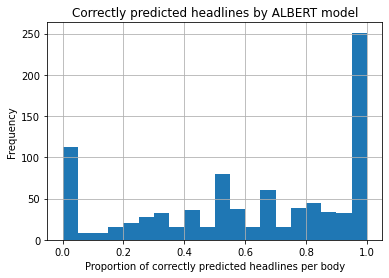

Mean props: 0.6156264617526495
std props: 0.34768929515036867


In [8]:
grouped_bodies = correct[['articleBody', 'correct_albert', 'correct_base']].groupby(['articleBody']).sum().sort_values('correct_albert', ascending=False)
grouped_bodies.reset_index(level=0, inplace=True)

pair_count = {}
rel_bodies = set(grouped_bodies['articleBody'].values)
# print(rel_headlines)
for body in rel_bodies:
    pair_count[body] = test_res_rel.loc[test_res_rel['articleBody'] == body].shape[0]

missed_count_albert = []
missed_count_base = []
total = []

for body in grouped_bodies['articleBody'].values:
    total.append(pair_count[body])
    missed_count_albert.append(pair_count[body] - grouped_bodies.loc[grouped_bodies['articleBody'] == body]['correct_albert'].values[0])
    missed_count_base.append(pair_count[body] - grouped_bodies.loc[grouped_bodies['articleBody'] == body]['correct_base'].values[0])
     
grouped_bodies['missed_albert'] = missed_count_albert
grouped_bodies['missed_base'] = missed_count_base
grouped_bodies['total'] = total
grouped_bodies['prop_albert'] = grouped_bodies['correct_albert'] / grouped_bodies['total']
grouped_bodies['prop_base'] = grouped_bodies['correct_base'] / grouped_bodies['total']

grouped_bodies['difference'] = grouped_bodies['correct_albert'] - grouped_bodies['correct_base']
display(grouped_bodies)
hist_range = [0,1]
plt.hist(grouped_bodies['prop_albert'], bins=20, range=hist_range)
plt.grid()
plt.title("Correctly predicted headlines by ALBERT model")
plt.ylabel('Frequency')
plt.xlabel('Proportion of correctly predicted headlines per body')
plt.savefig('prop_albert_bodies.pdf')
plt.show()
print(f"Mean props: {grouped_bodies['prop_albert'].mean()}")
print(f"std props: {grouped_bodies['prop_albert'].std()}")

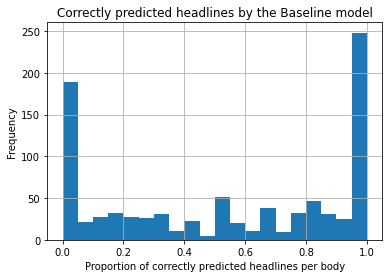

Mean props: 0.5376255515191547
std props: 0.3957769247290956


In [9]:
plt.hist(grouped_bodies['prop_base'], bins=20, range=hist_range)
plt.grid()
plt.title("Correctly predicted headlines by the Baseline model")
plt.ylabel('Frequency')
plt.xlabel('Proportion of correctly predicted headlines per body')
plt.savefig('prop_base_bodies.pdf')
plt.show()
print(f"Mean props: {grouped_bodies['prop_base'].mean()}")
print(f"std props: {grouped_bodies['prop_base'].std()}")

In [10]:
print(f"Mean correct albert: {correct_count['correct_albert'].mean()}")
print(f"Mean correct base: {correct_count['correct_base'].mean()}")

Mean correct albert: 5.19036954087346
Mean correct base: 4.562150055991041


# Aggregate by Headlines and Data Exploration

In [11]:
pair_count = {}
rel_headlines = set(test_res_rel['Headline'].values)
# print(rel_headlines)
for head in rel_headlines:
    pair_count[head] = test_res_rel.loc[test_res_rel['Headline'] == head].shape[0]
    
grouped_res = correct_count.copy()
missed_count_albert = []
missed_count_base = []
total = []

for headline in grouped_res['Headline'].values:
    total.append(pair_count[headline])
    missed_count_albert.append(pair_count[headline] - grouped_res.loc[grouped_res['Headline'] == headline]['correct_albert'].values[0])
    missed_count_base.append(pair_count[headline] - grouped_res.loc[grouped_res['Headline'] == headline]['correct_base'].values[0])
     
grouped_res['missed_albert'] = missed_count_albert
grouped_res['missed_base'] = missed_count_base
grouped_res['total'] = total

grouped_res['prop_albert'] = grouped_res['correct_albert'] / grouped_res['total']
grouped_res['prop_base'] = grouped_res['correct_base'] / grouped_res['total']

grouped_res['difference'] = grouped_res['correct_albert'] - grouped_res['correct_base']
display(grouped_res)
# display(grouped_res.loc[grouped_res['total'] > 20].sort_values('prop_albert', ascending=False))


,Headline,correct_albert,correct_base,missed_albert,missed_base,total,prop_albert,prop_base,difference
0,"Source: Joan Rivers' doc did biopsy, selfie",126,193,75,8,201,0.626866,0.960199,-67
1,Charles Manson’s fiancee allegedly wanted to m...,81,81,0,0,81,1.000000,1.000000,0
2,Joan Rivers Personal Doctor Allegedly Took A S...,55,82,35,8,90,0.611111,0.911111,-27
3,Disturbed aunt cuts off nephew’s penis after h...,41,41,16,16,57,0.719298,0.719298,0
4,Joan Rivers’ Doctor Snapped Selfie During Thro...,36,36,0,0,36,1.000000,1.000000,0
...,...,...,...,...,...,...,...,...,...
888,Son's Asinine Questions Inspire Priceless Dad-...,0,1,1,0,1,0.000000,1.000000,-1
889,Here's What We Know About ISIS's Alleged Organ...,0,6,7,1,7,0.000000,0.857143,-6
890,9 Things You Need To Know About The Climate Ch...,0,2,5,3,5,0.000000,0.400000,-2
891,Heart specialist questions benefits of high-in...,0,0,4,4,4,0.000000,0.000000,0


In [12]:
display(grouped_res[['Headline','difference','correct_albert','correct_base']].sort_values('difference', ascending=False))

,Headline,difference,correct_albert,correct_base
11,"Fake or freak? Woman, 21, claims to have paid ...",29,29,0
18,Florida woman gets third breast surgically imp...,18,27,9
23,Argentina’s President Adopted A Jewish Godson ...,18,22,4
28,Argentina's President Just Adopted a Son So He...,18,20,2
6,Saudi Arabia outlaws ‘tempting eyes’,17,33,16
...,...,...,...,...
437,A Russian Guy Says His Justin Bieber Ringtone ...,-16,3,19
452,This Woman Claims To Have Had Plastic Surgery ...,-17,3,20
122,Did Argentina's President Adopt A Jewish Baby ...,-19,10,29
2,Joan Rivers Personal Doctor Allegedly Took A S...,-27,55,82


In [13]:
display(grouped_res.sort_values(['prop_albert', 'total'], ascending=[True, False])[:10])

,Headline,correct_albert,correct_base,missed_albert,missed_base,total,prop_albert,prop_base,difference
785,Woman Who Claimed To Have Surgery To Add Third...,0,11,32,21,32,0.0,0.343750,-11
777,‘Three-boobed’ woman: They’re not fake,0,0,30,30,30,0.0,0.000000,0
861,The Story of the 3-Boobed Lady Is As Fake As H...,0,5,27,22,27,0.0,0.185185,-5
803,Iraqi Army Downs 2 UK Planes Carrying Weapons ...,0,0,20,20,20,0.0,0.000000,0
786,Woman Gets Third Boob to Appear Unattractive t...,0,3,18,15,18,0.0,0.166667,-3
783,Doc calls macabre 'selfie' claims completely c...,0,0,17,17,17,0.0,0.000000,0
799,Woman Adds Third Breast by Undergoing Surgery ...,0,5,17,12,17,0.0,0.294118,-5
849,HP Is Planning To Split Into Two Separate Busi...,0,4,14,10,14,0.0,0.285714,-4
865,This Campaign Shows A Pretty Genius Way To Sto...,0,1,12,11,12,0.0,0.083333,-1
883,A Pregnant Woman Has Lost Her Eye After Being ...,0,1,11,10,11,0.0,0.090909,-1


In [14]:
display(grouped_res.sort_values(['prop_base', 'total'], ascending=[True, False])[:10])

,Headline,correct_albert,correct_base,missed_albert,missed_base,total,prop_albert,prop_base,difference
11,"Fake or freak? Woman, 21, claims to have paid ...",29,0,10,39,39,0.743590,0.0,29
62,Meet the 3-boobed woman,14,0,24,38,38,0.368421,0.0,14
644,Three Boobs Are Most Likely Two Boobs and a Lie,1,0,35,36,36,0.027778,0.0,1
777,‘Three-boobed’ woman: They’re not fake,0,0,30,30,30,0.000000,0.0,0
126,Adopting Potential Werewolves Is Routine Busin...,10,0,15,25,25,0.400000,0.0,10
803,Iraqi Army Downs 2 UK Planes Carrying Weapons ...,0,0,20,20,20,0.000000,0.0,0
107,No gender segregation on Saudia,11,0,8,19,19,0.578947,0.0,11
783,Doc calls macabre 'selfie' claims completely c...,0,0,17,17,17,0.000000,0.0,0
540,Crabzilla,2,0,14,16,16,0.125000,0.0,2
337,Triple-breasted woman pictured before 'operati...,5,0,9,14,14,0.357143,0.0,5


In [15]:
print(f"Average score for albert: {grouped_res['prop_albert'].mean()} (sigma = {grouped_res['prop_albert'].std()})")
print(f"Average score for baseline: {grouped_res['prop_base'].mean()} (sigma = {grouped_res['prop_base'].std()})")

Average score for albert: 0.6165122554439664 (sigma = 0.3595390395650189)
Average score for baseline: 0.5125810211811731 (sigma = 0.38868813089802345)


In [16]:
failed_count_albert = grouped_res.loc[grouped_res['prop_albert'] < 0.001].shape[0]
failed_count_base = grouped_res.loc[grouped_res['prop_base'] < 0.001].shape[0]
print(f"Amount of headlines where models failed completely: albert: {failed_count_albert}, base: {failed_count_base}")
succ_count_albert = grouped_res.loc[grouped_res['prop_albert'] > 0.999].shape[0]
succ_count_base = grouped_res.loc[grouped_res['prop_base'] > 0.999].shape[0]
print(f"Amount of headlines where models scored perfectly: albert: {succ_count_albert}, base: {succ_count_base}")

Amount of headlines where models failed completely: albert: 122, base: 195
Amount of headlines where models scored perfectly: albert: 279, base: 228


# Appendix: Related Instances per body/headline

Amount of headlines that are outliers (larger than 50): 5


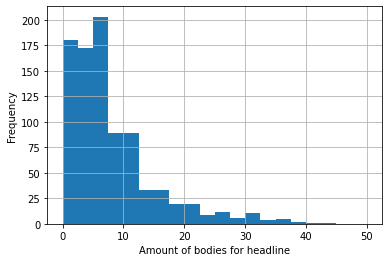

In [17]:
hist_range = [0, 50]
plt.hist(grouped_res['total'], bins=20, range=hist_range)
print(f"Amount of headlines that are outliers (larger than {hist_range[1]}): {grouped_res.loc[grouped_res['total'] > hist_range[1]].shape[0]}")
plt.grid()
plt.ylabel("Frequency")
plt.xlabel("Amount of bodies for headline")
plt.savefig('bodycount.pdf')
plt.show()

Amount of bodies that are outliers (larger than 50): 0


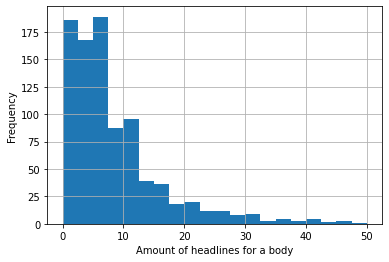

In [18]:
hist_range = [0, 50]
plt.hist(grouped_bodies['total'], bins=20, range=hist_range)
print(f"Amount of bodies that are outliers (larger than {hist_range[1]}): {grouped_res.loc[grouped_bodies['total'] > hist_range[1]].shape[0]}")
plt.grid()
plt.ylabel("Frequency")
plt.xlabel("Amount of headlines for a body")
plt.savefig('headlinecount.pdf')
plt.show()

# Figure 1: Performance per Aggregated Headline

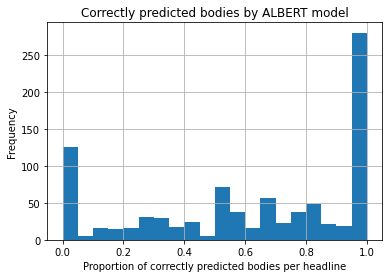

Mean ALBERT: 0.6165122554439664, std: 0.3595390395650189


In [19]:
hist_range = [0,1]
plt.hist(grouped_res['prop_albert'], bins=20, range=hist_range)
plt.grid()
plt.title("Correctly predicted bodies by ALBERT model")
plt.ylabel('Frequency')
plt.xlabel('Proportion of correctly predicted bodies per headline')
plt.savefig('prop_albert.pdf')
plt.show()
print(f"Mean ALBERT: {grouped_res['prop_albert'].mean()}, std: {grouped_res['prop_albert'].std()}")

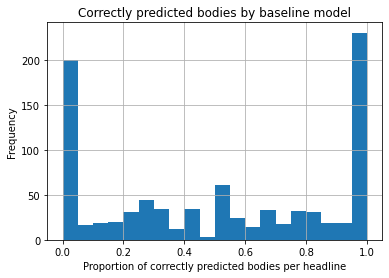

Mean base: 0.5125810211811731, std: 0.38868813089802345


In [20]:
hist_range = [0,1]
plt.hist(grouped_res['prop_base'], bins=20, range=hist_range)
plt.grid()
plt.title("Correctly predicted bodies by baseline model")
plt.ylabel('Frequency')
plt.xlabel('Proportion of correctly predicted bodies per headline')
plt.savefig('prop_base.pdf')
plt.show()
print(f"Mean base: {grouped_res['prop_base'].mean()}, std: {grouped_res['prop_base'].std()}")

# Result Analysis (Similarity between successful/unsuccessful groups)

In [21]:
correct_headlines_albert = set(grouped_res.loc[grouped_res['prop_albert'] > 0.99]['Headline'].values)
correct_headlines_base = set(grouped_res.loc[grouped_res['prop_base'] > 0.99]['Headline'].values)
failed_headlines_albert = set(grouped_res.loc[grouped_res['prop_albert'] < 0.01]['Headline'].values)
failed_headlines_base = set(grouped_res.loc[grouped_res['prop_base'] < 0.01]['Headline'].values)
print(f"Intersection size of set of correct headlines for albert ({len(correct_headlines_albert)}) and baseline ({len(correct_headlines_base)}): {len(correct_headlines_albert.intersection(correct_headlines_base))}")
print(f"Intersection size of set of failed headlines for albert ({len(failed_headlines_albert)}) and baseline ({len(failed_headlines_base)}): {len(failed_headlines_albert.intersection(failed_headlines_base))}")


Intersection size of set of correct headlines for albert (279) and baseline (228): 145
Intersection size of set of failed headlines for albert (122) and baseline (195): 55


In [22]:
failed_bodies_albert = set(grouped_bodies.loc[grouped_bodies['prop_albert'] < 0.001]['articleBody'].values)
failed_instances_headlines_albert = test_res_rel.loc[test_res_rel['Headline'].isin(failed_headlines_albert)][['Headline', 'articleBody']]
failed_instances_bodies_albert = test_res_rel.loc[test_res_rel['articleBody'].isin(failed_bodies_albert)][['Headline', 'articleBody']]
intersection = failed_instances_headlines_albert.merge(failed_instances_bodies_albert, 'inner', on=['Headline', 'articleBody'])
union = failed_instances_headlines_albert.merge(failed_instances_bodies_albert, 'outer', on=['Headline', 'articleBody'])
print(f"Body instances size: {failed_instances_bodies_albert.shape[0]}, headline instances size: {failed_instances_headlines_albert.shape[0]}")
print(f"Intersection: {intersection.shape[0]}, union: {union.shape[0]}")
print(f"Jaccard similarity: {intersection.shape[0] / union.shape[0]}")

Body instances size: 484, headline instances size: 613
Intersection: 94, union: 1003
Jaccard similarity: 0.09371884346959122


In [23]:
correct_bodies_albert = set(grouped_bodies.loc[grouped_bodies['prop_albert'] > 0.99]['articleBody'].values)
correct_instances_headlines_albert = test_res_rel.loc[test_res_rel['Headline'].isin(correct_headlines_albert)][['Headline', 'articleBody']]
correct_instances_bodies_albert = test_res_rel.loc[test_res_rel['articleBody'].isin(correct_bodies_albert)][['Headline', 'articleBody']]
intersection = correct_instances_headlines_albert.merge(correct_instances_bodies_albert, 'inner', on=['Headline', 'articleBody'])
union = correct_instances_headlines_albert.merge(correct_instances_bodies_albert, 'outer', on=['Headline', 'articleBody'])
print(f"Body instances size: {correct_instances_bodies_albert.shape[0]}, headline instances size: {correct_instances_headlines_albert.shape[0]}")
print(f"Intersection: {intersection.shape[0]}, union: {union.shape[0]}")
print(f"Jaccard similarity: {intersection.shape[0] / union.shape[0]}")

Body instances size: 1131, headline instances size: 1570
Intersection: 726, union: 2311
Jaccard similarity: 0.31414971873647773


# (Discarded) Lexical Overlap between successful and unsuccessful groups

In [24]:
punct = set(string.punctuation)
sw = stopwords.words('english')
punct.update(['`', '\'', '\'s', '’', '‘', '“', '”', '“', '``',"''"])
stemmer = PorterStemmer()
def tokenize_corpus(corpus):
    token_dict = {}
    result = []
    tf = {}
    for passage in corpus:
        tokens = word_tokenize(passage)
        tokenized = []
        for token in tokens:
            token = token.lower()
            if token not in sw and token not in punct:
                stem = stemmer.stem(token)
                tokenized.append(stem)
                token_dict[stem] = token
                if stem not in tf.keys():
                    tf[stem] = 0
                tf[stem] += 1
        result.append(tokenized)
    return (result, token_dict, tf)


In [25]:
def sort_dict(x):
    return [(k, v) for k, v in sorted(x.items(), key=lambda item: item[1], reverse=True)]

tokenized_set, token_dict1, tf1 = tokenize_corpus(correct_headlines_albert)
word_dict_albert = {}
for stem in tf1.keys():
    word_dict_albert[token_dict1[stem]] = tf1[stem]
    
word_dict_albert = sort_dict(word_dict_albert)


tokenized_set, token_dict2, tf2 = tokenize_corpus(correct_headlines_base)
word_dict_base = {}
for stem in tf2.keys():
    word_dict_base[token_dict2[stem]] = tf2[stem]
    
word_dict_base = sort_dict(word_dict_base)

t=15

word_freq_albert = word_dict_albert[:t]
word_freq_base = word_dict_base[:t]
print(f"Top {t} frequent words in successfull headlines of ALBERT: {word_freq_albert}")
print(f"Top {t} frequent words in successfull headlines of Baseline: {word_freq_base}")

overlap = len(set([w[0] for w in word_freq_albert]).intersection(set([w[0] for w in word_freq_base]))) / t
print(f"The overlap of this top {t} is {overlap}")

Top 15 frequent words in successfull headlines of ALBERT: [('apple', 66), ('reported', 60), ('watch', 34), ('isis', 27), ('reportedly', 20), ('rumor', 20), ('us', 17), ('may', 15), ('afghan', 15), ('airstrike', 15), ('killed', 14), ('missing', 13), ('saudi', 13), ('air', 13), ('woman', 13)]
Top 15 frequent words in successfull headlines of Baseline: [('apple', 75), ('reported', 54), ('watch', 40), ('isis', 31), ('may', 17), ('joan', 17), ('rivers', 17), ('rumor', 17), ('air', 17), ('doctor', 16), ('reportedly', 16), ('selfie', 15), ('us', 13), ('took', 12), ('foley', 12)]
The overlap of this top 15 is 0.6


In [26]:

tokenized_set, token_dict1, tf1 = tokenize_corpus(failed_headlines_albert)
word_dict_albert = {}
for stem in tf1.keys():
    word_dict_albert[token_dict1[stem]] = tf1[stem]
    
word_dict_albert = sort_dict(word_dict_albert)


tokenized_set, token_dict2, tf2 = tokenize_corpus(failed_headlines_base)
word_dict_base = {}
for stem in tf2.keys():
    word_dict_base[token_dict2[stem]] = tf2[stem]
    
word_dict_base = sort_dict(word_dict_base)

t=15

word_freq_albert = word_dict_albert[:t]
word_freq_base = word_dict_base[:t]
print(f"Top {t} frequent words in failed headlines of ALBERT: {word_freq_albert}")
print(f"Top {t} frequent words in failed headlines of Baseline: {word_freq_base}")

overlap = len(set([w[0] for w in word_freq_albert]).intersection(set([w[0] for w in word_freq_base]))) / t
print(f"The overlap of this top {t} is {overlap}")

Top 15 frequent words in failed headlines of ALBERT: [('woman', 12), ('isis', 12), ('penis', 8), ('report', 8), ('us', 7), ('kills', 6), ('cat', 6), ('apple', 5), ('shows', 5), ('claim', 5), ('iraqi', 5), ('weapons', 5), ('third', 5), ('men', 5), ('airstrikes', 5)]
Top 15 frequent words in failed headlines of Baseline: [('woman', 18), ('cat', 16), ('getting', 11), ('surgery', 11), ('eye', 10), ('gender', 8), ('bill', 8), ('missing', 8), ('note', 8), ('show', 8), ('men', 7), ('killed', 7), ('birthday', 7), ('party', 7), ('police', 7)]
The overlap of this top 15 is 0.2


In [27]:
display(grouped_res.loc[grouped_res['prop_albert'] < 0.001].sort_values('difference', ascending=True)[:10])

,Headline,correct_albert,correct_base,missed_albert,missed_base,total,prop_albert,prop_base,difference
785,Woman Who Claimed To Have Surgery To Add Third...,0,11,32,21,32,0.0,0.343750,-11
887,Sexually frustrated female owl killed male bec...,0,11,11,0,11,0.0,1.000000,-11
805,President of Argentina adopts Jewish godson to...,0,9,10,1,10,0.0,0.900000,-9
878,APPLE WATCH MAY GO ON SALE IN MARCH ACCORDING ...,0,8,8,0,8,0.0,1.000000,-8
822,British Jihadi Killed In US Airstrike - Reports,0,7,7,0,7,0.0,1.000000,-7
815,ISIS Might Be Harvesting Organs To Finance Ope...,0,7,10,3,10,0.0,0.700000,-7
889,Here's What We Know About ISIS's Alleged Organ...,0,6,7,1,7,0.0,0.857143,-6
844,BOOK: CHARLES MANSON’S FIANCÉ WANTED MARRIAGE ...,0,6,6,0,6,0.0,1.000000,-6
799,Woman Adds Third Breast by Undergoing Surgery ...,0,5,17,12,17,0.0,0.294118,-5
810,REPORT: ISIS FIGHTING JUST ONE MILE OUTSIDE BA...,0,5,7,2,7,0.0,0.714286,-5


In [28]:
display(grouped_res.loc[grouped_res['prop_base'] < 0.001].sort_values('difference', ascending=False)[:10])

,Headline,correct_albert,correct_base,missed_albert,missed_base,total,prop_albert,prop_base,difference
11,"Fake or freak? Woman, 21, claims to have paid ...",29,0,10,39,39,0.743590,0.0,29
62,Meet the 3-boobed woman,14,0,24,38,38,0.368421,0.0,14
107,No gender segregation on Saudia,11,0,8,19,19,0.578947,0.0,11
115,Ferguson protester shot in the eye with rubber...,10,0,2,12,12,0.833333,0.0,10
126,Adopting Potential Werewolves Is Routine Busin...,10,0,15,25,25,0.400000,0.0,10
145,Evil Aunt Hacks Off Toddlers Penis,9,0,1,10,10,0.900000,0.0,9
206,9-year-old girl pens touching letter to teache...,7,0,0,7,7,1.000000,0.0,7
224,Woman has surgery to get third breast: The thr...,7,0,6,13,13,0.538462,0.0,7
230,‘I will have justice for what they did to me’:...,7,0,2,9,9,0.777778,0.0,7
274,The men caught cat-calling and wolf whistling ...,6,0,3,9,9,0.666667,0.0,6


In [29]:
display(test_res_rel)

,Body ID,articleBody,Headline,Stance_true,Stance_albert,Stance_baseline
1,1,Al-Sisi has denied Israeli reports stating tha...,El-Sisi denies claims he'll give Sinai land to...,agree,agree,discuss
34,2,A bereaved Afghan mother took revenge on the T...,Afghan Mother Kills 25 Taliban Fighters In Sev...,agree,agree,discuss
107,3,CNBC is reporting Tesla has chosen Nevada as t...,REPORT: Tesla Chooses Nevada For Site Of Its M...,discuss,discuss,discuss
201,12,A 4-inch version of the iPhone 6 is said to be...,4-inch iPhone 6 reported to be in development,discuss,discuss,discuss
208,19,GR editor’s Note\n\nThere are no reports in th...,Iraqi Army Downs Two British Planes Carrying W...,discuss,discuss,discuss
...,...,...,...,...,...,...
26855,2586,Remember how much Republicans wanted to repeal...,A Sign That Obamacare Exchanges Are Failing,disagree,agree,unrelated
26856,2586,Remember how much Republicans wanted to repeal...,Republicans call Obamacare a 'failure.' These ...,agree,disagree,discuss
26857,2586,Remember how much Republicans wanted to repeal...,CBO’s Alternate Facts Show Obamacare is Unsust...,disagree,disagree,unrelated
26858,2586,Remember how much Republicans wanted to repeal...,Why Obamacare failed,disagree,agree,unrelated


In [30]:
tokenized_corpus = {}
bodies =  list(set(test_res_rel['articleBody'].values))
headlines = list(set(test_res_rel['Headline'].values))
corpus = bodies + headlines
for text in tqdm(corpus, total=len(corpus)):
    tokenized_corpus[text] = tokenize_corpus([text])[0][0]
    
print(len(tokenized_corpus))

  0%|          | 0/1793 [00:00<?, ?it/s]

1788


In [31]:
overlap = correct.copy()
overlap_values = []
i = 0
for (headline, body) in tqdm(overlap[['Headline', 'articleBody']].values, total=overlap.shape[0]):
        headline_token_set = set(tokenized_corpus[headline])
        body_token_set = set(tokenized_corpus[body])
        intersect = headline_token_set.intersection(body_token_set)
        union = headline_token_set.union(body_token_set)
        overl = len(intersect) / (len(headline_token_set))
#         if i < 2:
#             print("###########",i)
#             print(headline)
#             print(headline_token_set)
#             print(body)
#             print(body_token_set)
#             print(overl)
#             i += 1 
        overlap_values.append(overl)
overlap['overlap'] = overlap_values

  0%|          | 0/7509 [00:00<?, ?it/s]

In [32]:
display(overlap)

,articleBody,Headline,Stance_true,correct_albert,correct_base,overlap
1,Al-Sisi has denied Israeli reports stating tha...,El-Sisi denies claims he'll give Sinai land to...,agree,True,False,0.125000
34,A bereaved Afghan mother took revenge on the T...,Afghan Mother Kills 25 Taliban Fighters In Sev...,agree,True,False,0.916667
107,CNBC is reporting Tesla has chosen Nevada as t...,REPORT: Tesla Chooses Nevada For Site Of Its M...,discuss,True,True,0.625000
201,A 4-inch version of the iPhone 6 is said to be...,4-inch iPhone 6 reported to be in development,discuss,True,True,0.800000
208,GR editor’s Note\n\nThere are no reports in th...,Iraqi Army Downs Two British Planes Carrying W...,discuss,True,True,0.900000
...,...,...,...,...,...,...
26855,Remember how much Republicans wanted to repeal...,A Sign That Obamacare Exchanges Are Failing,disagree,False,False,0.750000
26856,Remember how much Republicans wanted to repeal...,Republicans call Obamacare a 'failure.' These ...,agree,False,False,0.500000
26857,Remember how much Republicans wanted to repeal...,CBO’s Alternate Facts Show Obamacare is Unsust...,disagree,True,False,0.500000
26858,Remember how much Republicans wanted to repeal...,Why Obamacare failed,disagree,False,False,1.000000


# (Discarded) Investigation whether Lexical Overlap between headline and body is correlated to performance

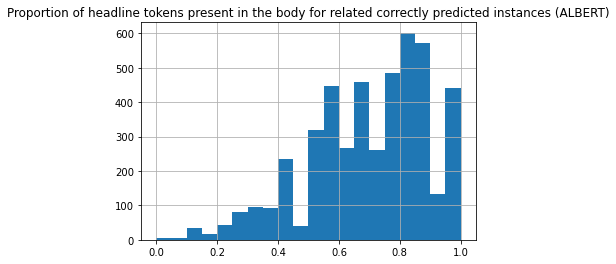

In [33]:
plt.hist(overlap.loc[overlap['correct_albert'] == True]['overlap'], bins = 20)
plt.title("Proportion of headline tokens present in the body for related correctly predicted instances (ALBERT)")
plt.grid()
plt.show()

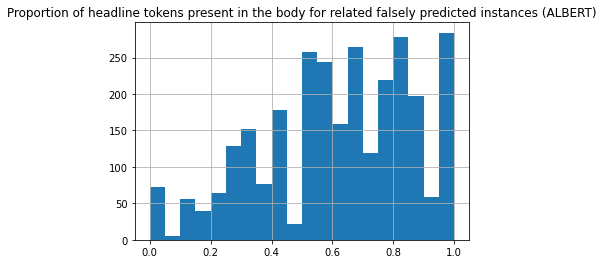

In [34]:
plt.hist(overlap.loc[overlap['correct_albert'] == False]['overlap'], bins = 20)
plt.title("Proportion of headline tokens present in the body for related falsely predicted instances (ALBERT)")
plt.grid()
plt.show()

In [35]:
# falsely_agr = []
# falsely_dsc = []
# falsely_dsg = []
# for headline in grouped_res['Headline'].values:
#     instances = test_res_rel.loc[(test_res_rel['Headline'] == headline)]
#     falsely_agr.append(instances.loc[intance['Stance_albert']])

# (Discarded) Jaccard Similarity Bet

In [36]:
failed_bodies = grouped_bodies.loc[grouped_bodies['prop_albert'] < 0.001]['articleBody'].values
failed_headlines = grouped_res.loc[grouped_res['prop_albert'] < 0.001]['Headline'].values
instances_bodies_failed = test_res_rel.loc[test_res_rel['articleBody'].isin(failed_bodies)][['Headline', 'articleBody']]
instances_headlines_failed = test_res_rel.loc[test_res_rel['Headline'].isin(failed_headlines)][['Headline', 'articleBody']]
print(instances_bodies_failed.shape)
print(instances_headlines_failed.shape)

print(pd.merge(instances_bodies_failed, instances_headlines_failed).shape)

(484, 2)
(613, 2)
(94, 2)


In [37]:
from itertools import chain
success_instances_albert_headlines = test_res_rel.loc[test_res_rel['Headline'].isin(correct_headlines_albert)][['Headline', 'articleBody']]
success_instances_albert_bodies = test_res_rel.loc[test_res_rel['articleBody'].isin(correct_bodies_albert)][['Headline', 'articleBody']]
success_merged_dfs = pd.merge(success_instances_albert_headlines,success_instances_albert_bodies,how='inner',on=['Headline', 'articleBody']).values
success_corpus =  list(chain.from_iterable(success_merged_dfs))

In [38]:
failed_instances_albert_headlines = test_res_rel.loc[test_res_rel['Headline'].isin(failed_headlines_albert)][['Headline', 'articleBody']]
failed_instances_albert_bodies = test_res_rel.loc[test_res_rel['articleBody'].isin(failed_bodies_albert)][['Headline', 'articleBody']]
failed_merged_dfs = pd.merge(failed_instances_albert_headlines,failed_instances_albert_bodies,how='inner',on=['Headline', 'articleBody']).values
failed_corpus =  list(chain.from_iterable(failed_merged_dfs))

In [39]:
tf_success = sort_dict(tokenize_corpus(success_corpus)[2])
tf_failed = sort_dict(tokenize_corpus(failed_corpus)[2])
# tf_success = sort_dict(tokenize_corpus(correct_headlines_albert)[2])
# tf_failed = sort_dict(tokenize_corpus(failed_headlines_albert)[2])

In [40]:
print(tf_success[:15])
print(tf_failed[:15])

[('appl', 2043), ('said', 1460), ('report', 1390), ('watch', 979), ('isi', 944), ('state', 890), ('display', 854), ('iraq', 796), ('sourc', 761), ('offici', 669), ('u.s.', 644), ('islam', 631), ('al-baghdadi', 627), ('leader', 620), ('iraqi', 618)]
[('fat', 535), ('satur', 312), ('heart', 231), ('said', 203), ('trump', 195), ('diseas', 179), ('report', 168), ('also', 164), ('say', 145), ('would', 144), ('studi', 142), ('russian', 138), ('kushner', 136), ('commun', 122), ('one', 116)]


In [53]:
T = [5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 500, 1000, 5000]
print("Jaccard similarity for")
for t in T:
    success_set = set([tf[0] for tf in tf_success[:t]])
    failed_set = set([tf[0] for tf in tf_failed[:t]])
    print(f"   - top {t} tokens: {len(success_set.intersection(failed_set))/len(success_set.union(failed_set))}")

Jaccard similarity for
   - top 5 tokens: 0.1111111111111111
   - top 10 tokens: 0.1111111111111111
   - top 15 tokens: 0.07142857142857142
   - top 20 tokens: 0.1111111111111111
   - top 25 tokens: 0.16279069767441862
   - top 30 tokens: 0.15384615384615385
   - top 40 tokens: 0.14285714285714285
   - top 50 tokens: 0.17647058823529413
   - top 60 tokens: 0.1650485436893204
   - top 70 tokens: 0.17647058823529413
   - top 80 tokens: 0.1678832116788321
   - top 90 tokens: 0.17647058823529413
   - top 100 tokens: 0.17647058823529413
   - top 200 tokens: 0.21212121212121213
   - top 300 tokens: 0.22950819672131148
   - top 500 tokens: 0.26422250316055623
   - top 1000 tokens: 0.32362673726009267
   - top 5000 tokens: 0.29986999855553953


# Appendix: Difficult Headlines/Body Examples

In [42]:
example_body_row = grouped_bodies.loc[(grouped_bodies['prop_albert'] < 0.001) & (grouped_bodies['total'] > 5)].loc[889]#.loc[grouped_bodies['Body ID'] == 2557]
# display(example_body_row)

In [43]:
print(f"Example Body:")
example_body = example_body_row['articleBody']
print(example_body)
associated_headlines = test_res_rel.loc[test_res_rel['articleBody'] == example_body]
print(f"Associated headlines n={associated_headlines.shape[0]}:")
display(associated_headlines)
print(associated_headlines['Headline'].values)

Example Body:
President-elect Donald J. Trump has not been inaugurated yet, but he's already backtracking on some of his most high-profile campaign positions.

The latest walk-back concerns global climate change: specificallys the agreement that world leaders recently put in place to rein in emissions of planet-warming greenhouse gases.

In an interview on Tuesday with senior reporters and editors of the New York Times, Trump said he has "an open mind" on whether to pull the U.S. out of the Paris Climate Agreement. “I’m looking at it very closely," he said

During the campaign, Trump was quite clear on this. During an energy policy speech on May 26, Trump said: “We’re going to cancel the Paris Climate Agreement and stop all payment of U.S. tax dollars to U.N. global warming programs."

During U.N. climate talks that ended this week, China emerged as the new leader on the issue if the U.S. were to stop mobilizing international support for climate action, as it has under President Obama.

,Body ID,articleBody,Headline,Stance_true,Stance_albert,Stance_baseline
26707,2557,President-elect Donald J. Trump has not been i...,Trump Plans to Pull out of Paris Climate Accord,disagree,discuss,discuss
26708,2557,President-elect Donald J. Trump has not been i...,Report: Trump Is Saying He Will Pull U.S. Out ...,disagree,discuss,discuss
26709,2557,President-elect Donald J. Trump has not been i...,Scoop: Trump tells confidants U.S. will quit P...,disagree,discuss,discuss
26710,2557,President-elect Donald J. Trump has not been i...,"For President Trump, Pulling Out Of Paris Is T...",disagree,discuss,unrelated
26711,2557,President-elect Donald J. Trump has not been i...,Trump has 'made up his mind to withdraw US fro...,disagree,discuss,discuss
26712,2557,President-elect Donald J. Trump has not been i...,Donald Trump walks back campaign pledges on an...,agree,discuss,discuss


['Trump Plans to Pull out of Paris Climate Accord'
 'Report: Trump Is Saying He Will Pull U.S. Out of Paris Climate Deal'
 'Scoop: Trump tells confidants U.S. will quit Paris climate deal'
 'For President Trump, Pulling Out Of Paris Is The Only Logical Move'
 "Trump has 'made up his mind to withdraw US from Paris climate deal' despite saying publicly he will decide next week"
 'Donald Trump walks back campaign pledges on another issue: climate change']


In [44]:
example_headline_row = grouped_res.loc[(grouped_res['prop_albert'] < 0.001) & (grouped_res['total'] < 10)].sample(n=1)


In [45]:
display(example_headline_row)
print(f"Example Headline:")
example_headline = example_headline_row['Headline'].values[0]
print(example_headline)
associated_bodies = test_res_rel.loc[test_res_rel['Headline'] == example_headline]
print(f"Associated bodies n={associated_bodies.shape[0]}:")
display(associated_bodies[['articleBody', 'Stance_true', 'Stance_albert', 'Stance_baseline']])
print([body[:100] for body in associated_bodies['articleBody']])

,Headline,correct_albert,correct_base,missed_albert,missed_base,total,prop_albert,prop_base,difference
811,REPORT: MARINES ORDERED BY STATE DEPT TO SURRE...,0,5,5,0,5,0.0,1.0,-5


Example Headline:
REPORT: MARINES ORDERED BY STATE DEPT TO SURRENDER WEAPONS IN US EMBASSY EVAC IN YEMEN
Associated bodies n=5:


,articleBody,Stance_true,Stance_albert,Stance_baseline
2700,**Update added (see below)**\n\nIn a report th...,discuss,unrelated,discuss
3135,Central Command reportedly is furious over a S...,discuss,unrelated,discuss
4626,"Sanaa, Yemen (CNN)Houthi rebels took all U.S. ...",discuss,unrelated,discuss
8311,Yemen’s Houthi rebels seized weapons from U.S....,discuss,unrelated,discuss
13938,It's Benghazi redux: As they secured the U.S. ...,discuss,unrelated,discuss


['**Update added (see below)**\n\nIn a report that aired on Fox News Channel’s “The Kelly File,” host Me', 'Central Command reportedly is furious over a State Department order that Marines guarding the U.S. E', "Sanaa, Yemen (CNN)Houthi rebels took all U.S. Embassy vehicles parked at the Yemeni capital's airpor", 'Yemen’s Houthi rebels seized weapons from U.S. Marines as well as several vehicles used by Americans', "It's Benghazi redux: As they secured the U.S. embassy in Yemen, the final Marines to leave the count"]


# Corpus Statistics

In [50]:
train_bodies = pd.read_csv(TRAIN_BODIES_PATH, names=['Body ID', 'articleBody'], header=0)
train_stances = pd.read_csv(TRAIN_STANCES_PATH, names=['Headline', 'Body ID', 'Stance'], header=0)

test_bodies = pd.read_csv(TEST_BODIES_PATH, names=['Body ID', 'articleBody'], header=0)
test_stances = pd.read_csv(TEST_STANCES_PATH, names=['Headline', 'Body ID', 'Stance'], header=0)



print("Num headlines:", len(set(test_stances['Headline'])) + len(set(train_stances['Headline'])))
print("Num bodies:", len(set(test_bodies['articleBody'].values)) + len(set(train_bodies['articleBody'].values)))
print("Num instances:", train_stances.shape[0] + test_stances.shape[0])

stance_count = {}
all_stances = np.concatenate((train_stances['Stance'].values, test_stances['Stance'].values))
for stance in all_stances:
    if stance not in stance_count.keys():
        stance_count[stance] = 0
    else:
        stance_count[stance] += 1
print(stance_count)
stance_freq = [count / len(all_stances) for count in stance_count.values()]
print(stance_freq)

Num headlines: 2542
Num bodies: 2569
Num instances: 75385
{'unrelated': 54893, 'agree': 5580, 'disagree': 1536, 'discuss': 13372}
[0.7281687338329906, 0.07402003051004842, 0.020375406247927306, 0.177382768455263]
